In [19]:
import numpy as np
import pandas as pd

# Load the feature mapping
data_dir = '../dataset'
feature_mapping_file = f'{data_dir}/meta/idx_to_feature_name.csv'
feature_mapping = pd.read_csv(feature_mapping_file)
print(feature_mapping.head())

# Load an example feature file
example_feature_file = f'{data_dir}/scenes/npy/9_speech_true_Radio_aus.npy'
features = np.load(example_feature_file)
print(f'Feature shape: {features.shape}')
print(features)


   index feature_name
0      0  bandwidth_0
1      1   centroid_0
2      2   contrast_0
3      3   contrast_1
4      4   contrast_2
Feature shape: (175, 503)
[[0.00000000e+00 0.00000000e+00 3.55572597e+03 ... 3.16909110e+03
  3.21029245e+03 3.29810116e+03]
 [0.00000000e+00 0.00000000e+00 2.94330233e+03 ... 2.32232569e+03
  2.16694691e+03 3.32197793e+03]
 [1.06553228e+01 1.06553228e+01 3.97100957e+00 ... 3.03475966e+00
  5.83976492e+00 1.14490307e+00]
 ...
 [0.00000000e+00 0.00000000e+00 5.72300705e-05 ... 1.68575775e-02
  1.34523511e-02 3.48735875e-06]
 [8.00000000e+03 1.00000000e+02 8.00000000e+03 ... 1.01880960e+02
  1.29330128e+02 8.00000000e+03]
 [0.00000000e+00 0.00000000e+00 1.22500000e-01 ... 1.47500000e-01
  9.00000000e-02 2.00000000e-02]]


2024-06-05 08:15:12,233 - INFO - Loading annotations...
2024-06-05 08:15:12,255 - INFO - Annotations loaded.


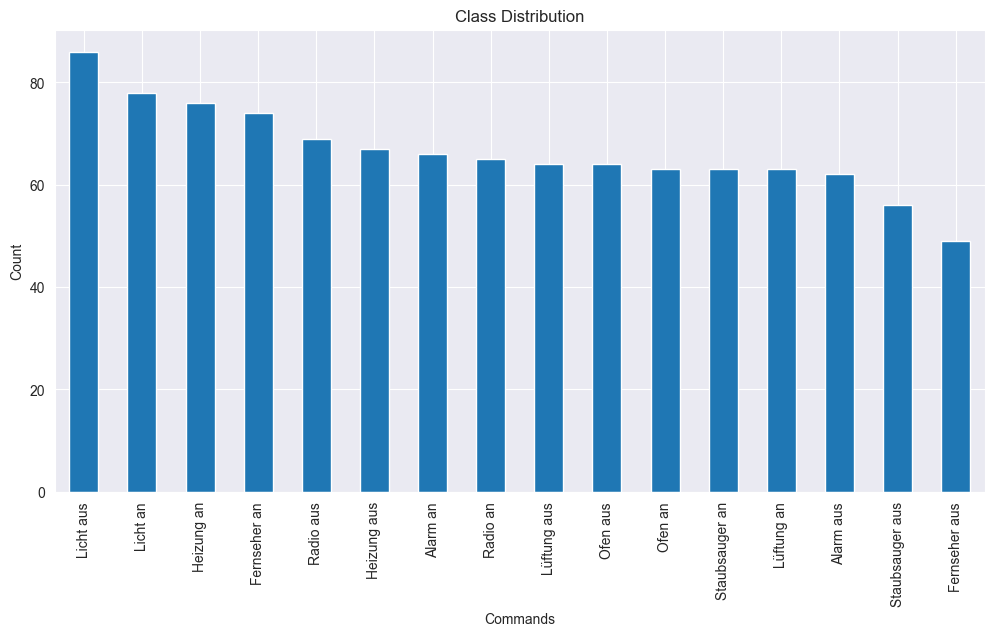

2024-06-05 08:15:12,579 - INFO - Preparing command data...
100%|██████████| 1065/1065 [00:01<00:00, 567.18it/s]
2024-06-05 08:15:15,956 - INFO - Command data prepared.
2024-06-05 08:15:24,786 - INFO - Command mapping: {'Licht aus': 0, 'Ofen an': 1, 'Radio an': 2, 'Fernseher an': 3, 'Heizung aus': 4, 'Alarm an': 5, 'Lüftung aus': 6, 'Staubsauger aus': 7, 'Heizung an': 8, 'Staubsauger an': 9, 'Alarm aus': 10, 'Licht an': 11, 'Ofen aus': 12, 'Radio aus': 13, 'Lüftung an': 14, 'Fernseher aus': 15}
2024-06-05 08:15:38,013 - INFO - Training command recognition model...


Epoch 1/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 33s 527ms/step - accuracy: 0.0543 - loss: 4.2300 - val_accuracy: 0.0704 - val_loss: 2.8035
Epoch 2/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 27s 498ms/step - accuracy: 0.0773 - loss: 2.7978 - val_accuracy: 0.0634 - val_loss: 2.8346
Epoch 3/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 27s 503ms/step - accuracy: 0.0705 - loss: 2.8442 - val_accuracy: 0.0798 - val_loss: 2.8394
Epoch 4/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 27s 496ms/step - accuracy: 0.1075 - loss: 2.8468 - val_accuracy: 0.0563 - val_loss: 2.8720
Epoch 5/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 29s 523ms/step - accuracy: 0.0645 - loss: 2.8424 - val_accuracy: 0.0469 - val_loss: 2.8253
Epoch 6/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 28s 518ms/step - accuracy: 0.0641 - loss: 2.8241 - val_accuracy: 0.0610 - val_loss: 2.8158
Epoch 7/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 27s 499ms/step - accuracy: 0.0586 - loss: 2.8232 - val_accuracy: 0.0681 - val_loss: 2.8417
Epoch 8/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 27s 502ms/step - accuracy: 0.0613 - loss: 2.8377 - val_accu

2024-06-05 08:45:26,300 - INFO - Command recognition model trained.


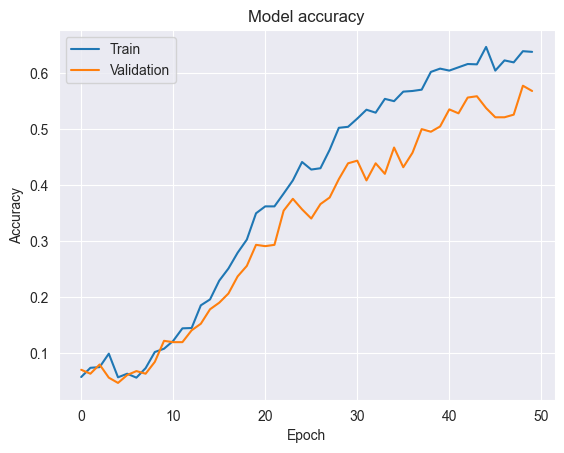

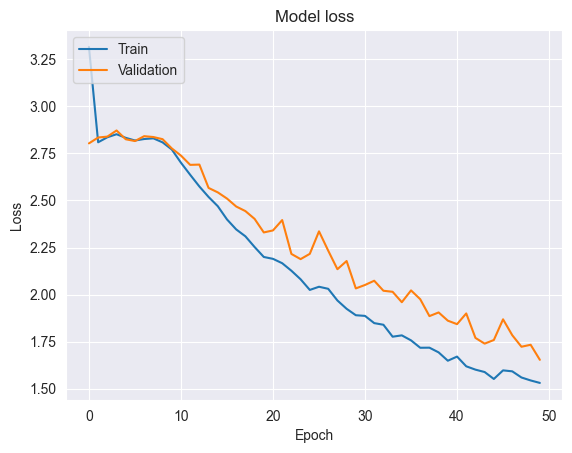

In [47]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tqdm import tqdm
import logging
import matplotlib.pyplot as plt
from sklearn.utils import class_weight

# Setup logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

data_dir = '../dataset'
annotations_file = f'{data_dir}/development_scene_annotations.csv'
model_save_path = 'best_command_model.keras'

# Load annotations
logging.info('Loading annotations...')
annotations = pd.read_csv(annotations_file)
logging.info('Annotations loaded.')

# Check class distribution
class_counts = annotations['command'].value_counts()
plt.figure(figsize=(12, 6))
class_counts.plot(kind='bar')
plt.title('Class Distribution')
plt.xlabel('Commands')
plt.ylabel('Count')
plt.show()

def prepare_feature_data(annotations, data_dir, feature_dir):
    command_features = []
    command_labels = []
    command_mapping = {}  # Mapping of command texts to numerical labels
    current_label = 0
    max_len = 0  # To determine the maximum length of features

    logging.info('Preparing command data...')
    for index, row in tqdm(annotations.iterrows(), total=annotations.shape[0]):
        feature_path = os.path.join(feature_dir, row['filename'] + '.npy')
        features = np.load(feature_path)
        max_len = max(max_len, features.shape[1])  # Update max_len
        
        command_text = row['command']
        if command_text not in command_mapping:
            command_mapping[command_text] = current_label
            current_label += 1
        
        command_label = command_mapping[command_text]
        
        command_features.append(features)
        command_labels.append(command_label)

    # Pad features to the same length
    padded_features = []
    for feature in command_features:
        pad_width = max_len - feature.shape[1]
        if pad_width > 0:
            feature = np.pad(feature, ((0, 0), (0, pad_width)), mode='constant')
        padded_features.append(feature)
    
    logging.info('Command data prepared.')
    return np.array(padded_features), np.array(command_labels), command_mapping

# Prepare feature-based command data
feature_dir = f'{data_dir}/scenes/npy'
command_features, command_labels, command_mapping = prepare_feature_data(annotations, data_dir, feature_dir)

# Normalize features across each feature dimension
command_features = (command_features - np.mean(command_features, axis=(0, 2), keepdims=True)) / np.std(command_features, axis=(0, 2), keepdims=True)

# One-hot encode labels
num_classes = len(command_mapping)
command_labels = to_categorical(command_labels, num_classes=num_classes)

logging.info(f'Command mapping: {command_mapping}')

# Data Augmentation Function
def augment_data(features, noise_factor=0.005):
    noise = np.random.randn(*features.shape) * noise_factor
    augmented_features = features + noise
    augmented_features = np.clip(augmented_features, -1.0, 1.0)
    return augmented_features

# Augment the training data
augmented_features = augment_data(command_features)
combined_features = np.concatenate((command_features, augmented_features), axis=0)
combined_labels = np.concatenate((command_labels, command_labels), axis=0)

# Calculate class weights
class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(np.argmax(command_labels, axis=1)), y=np.argmax(command_labels, axis=1))
class_weights = dict(enumerate(class_weights))

# GRU with Attention Model
def attention_block(inputs):
    attention = layers.Dense(1, activation='tanh')(inputs)
    attention = layers.Flatten()(attention)
    attention = layers.Activation('softmax')(attention)
    attention = layers.RepeatVector(inputs.shape[-1])(attention)
    attention = layers.Permute([2, 1])(attention)
    output_attention = layers.Multiply()([inputs, attention])
    return output_attention

def build_gru_attention_model(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)
    x = layers.GRU(128, return_sequences=True)(inputs)
    x = layers.Dropout(0.5)(x)
    x = layers.GRU(128, return_sequences=True)(x)
    x = layers.Dropout(0.5)(x)
    x = attention_block(x)
    x = layers.Flatten()(x)
    x = layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    model = models.Model(inputs, outputs)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

input_shape = (command_features.shape[1], command_features.shape[2])
command_model = build_gru_attention_model(input_shape, num_classes)

logging.info('Training command recognition model...')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint(model_save_path, save_best_only=True, monitor='val_loss')

history = command_model.fit(combined_features, combined_labels, epochs=50, batch_size=32, validation_split=0.2,
                            callbacks=[early_stopping, model_checkpoint], class_weight=class_weights)
logging.info('Command recognition model trained.')

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


In [50]:
import os
import numpy as np
import tensorflow as tf
import logging
import pandas as pd
import random
from tqdm import tqdm

# Setup logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

data_dir = '../dataset'
model_save_path = 'best_command_model.keras'
annotations_file = f'{data_dir}/development_scene_annotations.csv'

# Load annotations to get command mapping
logging.info('Loading annotations...')
annotations = pd.read_csv(annotations_file)
logging.info('Annotations loaded.')

# Extract command mapping
command_mapping = {}
current_label = 0
for command in annotations['command'].unique():
    command_mapping[command] = current_label
    current_label += 1

# Reverse command mapping
reverse_command_mapping = {v: k for k, v in command_mapping.items()}

# Load the best model
logging.info('Loading the best model...')
command_model = tf.keras.models.load_model(model_save_path)
logging.info('Model loaded.')


# Function to prepare feature data (from the training script)
def prepare_feature_data(annotations, data_dir, feature_dir):
    command_features = []
    command_labels = []
    command_mapping = {}  # Mapping of command texts to numerical labels
    current_label = 0
    max_len = 0  # To determine the maximum length of features

    logging.info('Preparing command data...')
    for index, row in tqdm(annotations.iterrows(), total=annotations.shape[0]):
        feature_path = os.path.join(feature_dir, row['filename'] + '.npy')
        features = np.load(feature_path)
        max_len = max(max_len, features.shape[1])  # Update max_len

        command_text = row['command']
        if command_text not in command_mapping:
            command_mapping[command_text] = current_label
            current_label += 1

        command_label = command_mapping[command_text]

        command_features.append(features)
        command_labels.append(command_label)

    # Pad features to the same length
    padded_features = []
    for feature in command_features:
        pad_width = max_len - feature.shape[1]
        if pad_width > 0:
            feature = np.pad(feature, ((0, 0), (0, pad_width)), mode='constant')
        padded_features.append(feature)

    logging.info('Command data prepared.')
    return np.array(padded_features), np.array(command_labels), command_mapping, max_len


# Calculate mean, std, and max_len from training data
feature_dir = f'{data_dir}/scenes/npy'
annotations = pd.read_csv(annotations_file)
command_features, _, _, max_len = prepare_feature_data(annotations, data_dir, feature_dir)
mean = np.mean(command_features, axis=(0, 2), keepdims=True)
std = np.std(command_features, axis=(0, 2), keepdims=True)


# Function to prepare new data for prediction
def prepare_new_data(new_feature_file, mean, std, max_len):
    new_features = np.load(new_feature_file)
    new_features = np.pad(new_features, ((0, 0), (0, max_len - new_features.shape[1])), mode='constant')
    new_features = (new_features - mean) / std
    #new_features = new_features.reshape(1, new_features.shape[0], new_features.shape[1])
    return new_features


# Function to predict and assess accuracy
def predict_command(file_path):
    new_features = prepare_new_data(file_path, mean, std, max_len)
    predicted_command = command_model.predict(new_features)
    predicted_label = np.argmax(predicted_command)
    confidence = np.max(predicted_command)
    predicted_command_text = reverse_command_mapping[predicted_label]
    return predicted_command_text, confidence


# Loop over random files and assess accuracy
num_files_to_evaluate = 100
random_files = random.sample(list(annotations['filename'].unique()), num_files_to_evaluate)

correct_predictions = 0
total_predictions = 0

for file_name in random_files:
    file_path = os.path.join(feature_dir, f"{file_name}.npy")
    actual_command = annotations[annotations['filename'] == file_name]['command'].values[0]
    predicted_command_text, confidence = predict_command(file_path)

    logging.info(f"File: {file_name}")
    logging.info(f"Actual Command: {actual_command}")
    logging.info(f"Predicted Command: {predicted_command_text}")
    logging.info(f"Confidence: {confidence:.2f}")

    if actual_command == predicted_command_text:
        correct_predictions += 1
    total_predictions += 1

accuracy = correct_predictions / total_predictions
logging.info(f"Overall Accuracy: {accuracy:.2%}")


2024-06-05 09:19:35,332 - INFO - Loading annotations...
2024-06-05 09:19:35,348 - INFO - Annotations loaded.
2024-06-05 09:19:35,350 - INFO - Loading the best model...
2024-06-05 09:19:35,922 - INFO - Model loaded.
2024-06-05 09:19:35,927 - INFO - Preparing command data...
100%|██████████| 1065/1065 [00:01<00:00, 622.77it/s]
2024-06-05 09:19:38,582 - INFO - Command data prepared.


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 508ms/step


2024-06-05 09:19:43,051 - INFO - File: 215_speech_false_Heizung_aus_Licht_aus
2024-06-05 09:19:43,052 - INFO - Actual Command: Heizung aus
2024-06-05 09:19:43,052 - INFO - Predicted Command: Heizung aus
2024-06-05 09:19:43,054 - INFO - Confidence: 0.41


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


2024-06-05 09:19:43,164 - INFO - File: 1383_speech_false_Alarm_an
2024-06-05 09:19:43,165 - INFO - Actual Command: Alarm an
2024-06-05 09:19:43,165 - INFO - Predicted Command: Alarm an
2024-06-05 09:19:43,165 - INFO - Confidence: 0.83


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


2024-06-05 09:19:43,257 - INFO - File: 1726_speech_true_Heizung_aus
2024-06-05 09:19:43,258 - INFO - Actual Command: Heizung aus
2024-06-05 09:19:43,258 - INFO - Predicted Command: Heizung aus
2024-06-05 09:19:43,259 - INFO - Confidence: 0.69


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


2024-06-05 09:19:43,376 - INFO - File: 1817_speech_true_Heizung_aus
2024-06-05 09:19:43,377 - INFO - Actual Command: Heizung aus
2024-06-05 09:19:43,377 - INFO - Predicted Command: Heizung aus
2024-06-05 09:19:43,378 - INFO - Confidence: 0.71


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


2024-06-05 09:19:43,482 - INFO - File: 560_speech_false_Lüftung_aus
2024-06-05 09:19:43,483 - INFO - Actual Command: Lüftung aus
2024-06-05 09:19:43,483 - INFO - Predicted Command: Lüftung aus
2024-06-05 09:19:43,484 - INFO - Confidence: 0.83


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


2024-06-05 09:19:43,584 - INFO - File: 515_speech_false_Alarm_aus_Radio_aus
2024-06-05 09:19:43,585 - INFO - Actual Command: Alarm aus
2024-06-05 09:19:43,585 - INFO - Predicted Command: Alarm aus
2024-06-05 09:19:43,586 - INFO - Confidence: 0.55


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


2024-06-05 09:19:43,683 - INFO - File: 1689_speech_true_Ofen_aus
2024-06-05 09:19:43,684 - INFO - Actual Command: Ofen aus
2024-06-05 09:19:43,684 - INFO - Predicted Command: Ofen aus
2024-06-05 09:19:43,685 - INFO - Confidence: 0.77


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


2024-06-05 09:19:43,807 - INFO - File: 1708_speech_true_Staubsauger_an
2024-06-05 09:19:43,807 - INFO - Actual Command: Staubsauger an
2024-06-05 09:19:43,808 - INFO - Predicted Command: Staubsauger an
2024-06-05 09:19:43,808 - INFO - Confidence: 0.88


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


2024-06-05 09:19:43,916 - INFO - File: 595_speech_false_Fernseher_aus
2024-06-05 09:19:43,916 - INFO - Actual Command: Fernseher aus
2024-06-05 09:19:43,916 - INFO - Predicted Command: Fernseher aus
2024-06-05 09:19:43,917 - INFO - Confidence: 0.89


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


2024-06-05 09:19:44,027 - INFO - File: 1148_speech_true_Ofen_aus_Radio_aus_Staubsauger_aus
2024-06-05 09:19:44,027 - INFO - Actual Command: Ofen aus
2024-06-05 09:19:44,028 - INFO - Predicted Command: Radio aus
2024-06-05 09:19:44,028 - INFO - Confidence: 0.33


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


2024-06-05 09:19:44,135 - INFO - File: 1909_speech_false_Alarm_aus
2024-06-05 09:19:44,135 - INFO - Actual Command: Alarm aus
2024-06-05 09:19:44,136 - INFO - Predicted Command: Alarm aus
2024-06-05 09:19:44,136 - INFO - Confidence: 0.74


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


2024-06-05 09:19:44,235 - INFO - File: 33_speech_false_Staubsauger_an
2024-06-05 09:19:44,235 - INFO - Actual Command: Staubsauger an
2024-06-05 09:19:44,236 - INFO - Predicted Command: Staubsauger an
2024-06-05 09:19:44,236 - INFO - Confidence: 0.90


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


2024-06-05 09:19:44,346 - INFO - File: 1752_speech_true_Fernseher_aus_Alarm_aus
2024-06-05 09:19:44,347 - INFO - Actual Command: Fernseher aus
2024-06-05 09:19:44,347 - INFO - Predicted Command: Fernseher aus
2024-06-05 09:19:44,348 - INFO - Confidence: 0.65


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


2024-06-05 09:19:44,438 - INFO - File: 382_speech_false_Staubsauger_an
2024-06-05 09:19:44,439 - INFO - Actual Command: Staubsauger an
2024-06-05 09:19:44,440 - INFO - Predicted Command: Staubsauger an
2024-06-05 09:19:44,440 - INFO - Confidence: 0.90


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


2024-06-05 09:19:44,524 - INFO - File: 2006_speech_true_Alarm_aus
2024-06-05 09:19:44,524 - INFO - Actual Command: Alarm aus
2024-06-05 09:19:44,525 - INFO - Predicted Command: Alarm aus
2024-06-05 09:19:44,526 - INFO - Confidence: 0.66


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


2024-06-05 09:19:44,613 - INFO - File: 1292_speech_false_Ofen_an
2024-06-05 09:19:44,614 - INFO - Actual Command: Ofen an
2024-06-05 09:19:44,614 - INFO - Predicted Command: Ofen an
2024-06-05 09:19:44,615 - INFO - Confidence: 0.82


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


2024-06-05 09:19:44,703 - INFO - File: 1822_speech_true_Heizung_an
2024-06-05 09:19:44,704 - INFO - Actual Command: Heizung an
2024-06-05 09:19:44,704 - INFO - Predicted Command: Heizung an
2024-06-05 09:19:44,705 - INFO - Confidence: 0.86


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


2024-06-05 09:19:44,785 - INFO - File: 404_speech_true_Lüftung_aus
2024-06-05 09:19:44,786 - INFO - Actual Command: Lüftung aus
2024-06-05 09:19:44,786 - INFO - Predicted Command: Lüftung aus
2024-06-05 09:19:44,787 - INFO - Confidence: 0.84


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


2024-06-05 09:19:44,870 - INFO - File: 1039_speech_false_Heizung_an
2024-06-05 09:19:44,870 - INFO - Actual Command: Heizung an
2024-06-05 09:19:44,871 - INFO - Predicted Command: Heizung an
2024-06-05 09:19:44,872 - INFO - Confidence: 0.85


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


2024-06-05 09:19:44,960 - INFO - File: 940_speech_true_Lüftung_aus
2024-06-05 09:19:44,961 - INFO - Actual Command: Lüftung aus
2024-06-05 09:19:44,961 - INFO - Predicted Command: Lüftung aus
2024-06-05 09:19:44,962 - INFO - Confidence: 0.78


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


2024-06-05 09:19:45,043 - INFO - File: 68_speech_true_Heizung_an
2024-06-05 09:19:45,043 - INFO - Actual Command: Heizung an
2024-06-05 09:19:45,044 - INFO - Predicted Command: Heizung an
2024-06-05 09:19:45,044 - INFO - Confidence: 0.84


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


2024-06-05 09:19:45,132 - INFO - File: 644_speech_false_Licht_aus
2024-06-05 09:19:45,133 - INFO - Actual Command: Licht aus
2024-06-05 09:19:45,133 - INFO - Predicted Command: Licht aus
2024-06-05 09:19:45,133 - INFO - Confidence: 0.73


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


2024-06-05 09:19:45,216 - INFO - File: 1172_speech_false_Radio_aus_Staubsauger_an
2024-06-05 09:19:45,216 - INFO - Actual Command: Radio aus
2024-06-05 09:19:45,216 - INFO - Predicted Command: Staubsauger an
2024-06-05 09:19:45,217 - INFO - Confidence: 0.15


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


2024-06-05 09:19:45,305 - INFO - File: 1452_speech_false_Radio_an
2024-06-05 09:19:45,305 - INFO - Actual Command: Radio an
2024-06-05 09:19:45,305 - INFO - Predicted Command: Radio an
2024-06-05 09:19:45,306 - INFO - Confidence: 0.88


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


2024-06-05 09:19:45,389 - INFO - File: 513_speech_false_Staubsauger_aus
2024-06-05 09:19:45,389 - INFO - Actual Command: Staubsauger aus
2024-06-05 09:19:45,389 - INFO - Predicted Command: Staubsauger aus
2024-06-05 09:19:45,390 - INFO - Confidence: 0.38


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


2024-06-05 09:19:45,468 - INFO - File: 713_speech_false_Ofen_an
2024-06-05 09:19:45,469 - INFO - Actual Command: Ofen an
2024-06-05 09:19:45,469 - INFO - Predicted Command: Ofen an
2024-06-05 09:19:45,470 - INFO - Confidence: 0.80


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


2024-06-05 09:19:45,547 - INFO - File: 140_speech_true_Fernseher_an
2024-06-05 09:19:45,547 - INFO - Actual Command: Fernseher an
2024-06-05 09:19:45,548 - INFO - Predicted Command: Fernseher an
2024-06-05 09:19:45,548 - INFO - Confidence: 0.76


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


2024-06-05 09:19:45,631 - INFO - File: 577_speech_true_Staubsauger_aus
2024-06-05 09:19:45,631 - INFO - Actual Command: Staubsauger aus
2024-06-05 09:19:45,631 - INFO - Predicted Command: Staubsauger aus
2024-06-05 09:19:45,632 - INFO - Confidence: 0.77


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


2024-06-05 09:19:45,713 - INFO - File: 308_speech_true_Heizung_an
2024-06-05 09:19:45,714 - INFO - Actual Command: Heizung an
2024-06-05 09:19:45,714 - INFO - Predicted Command: Heizung an
2024-06-05 09:19:45,714 - INFO - Confidence: 0.86


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


2024-06-05 09:19:45,794 - INFO - File: 929_speech_true_Lüftung_an
2024-06-05 09:19:45,794 - INFO - Actual Command: Lüftung an
2024-06-05 09:19:45,795 - INFO - Predicted Command: Lüftung an
2024-06-05 09:19:45,795 - INFO - Confidence: 0.86


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


2024-06-05 09:19:45,877 - INFO - File: 873_speech_true_Lüftung_aus
2024-06-05 09:19:45,877 - INFO - Actual Command: Lüftung aus
2024-06-05 09:19:45,877 - INFO - Predicted Command: Lüftung aus
2024-06-05 09:19:45,878 - INFO - Confidence: 0.83


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


2024-06-05 09:19:45,964 - INFO - File: 1844_speech_true_Lüftung_aus
2024-06-05 09:19:45,964 - INFO - Actual Command: Lüftung aus
2024-06-05 09:19:45,964 - INFO - Predicted Command: Lüftung aus
2024-06-05 09:19:45,965 - INFO - Confidence: 0.80


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


2024-06-05 09:19:46,047 - INFO - File: 992_speech_true_Radio_an
2024-06-05 09:19:46,047 - INFO - Actual Command: Radio an
2024-06-05 09:19:46,048 - INFO - Predicted Command: Radio an
2024-06-05 09:19:46,048 - INFO - Confidence: 0.90


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


2024-06-05 09:19:46,128 - INFO - File: 1788_speech_false_Lüftung_aus_Licht_an
2024-06-05 09:19:46,128 - INFO - Actual Command: Lüftung aus
2024-06-05 09:19:46,129 - INFO - Predicted Command: Lüftung aus
2024-06-05 09:19:46,129 - INFO - Confidence: 0.45


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


2024-06-05 09:19:46,217 - INFO - File: 1131_speech_true_Radio_aus_Lüftung_aus
2024-06-05 09:19:46,218 - INFO - Actual Command: Radio aus
2024-06-05 09:19:46,218 - INFO - Predicted Command: Alarm aus
2024-06-05 09:19:46,218 - INFO - Confidence: 0.32


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


2024-06-05 09:19:46,296 - INFO - File: 1400_speech_true_Radio_an
2024-06-05 09:19:46,296 - INFO - Actual Command: Radio an
2024-06-05 09:19:46,297 - INFO - Predicted Command: Radio an
2024-06-05 09:19:46,297 - INFO - Confidence: 0.90


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


2024-06-05 09:19:46,376 - INFO - File: 1876_speech_true_Radio_an_Radio_aus
2024-06-05 09:19:46,376 - INFO - Actual Command: Radio an
2024-06-05 09:19:46,377 - INFO - Predicted Command: Radio an
2024-06-05 09:19:46,377 - INFO - Confidence: 0.61


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


2024-06-05 09:19:46,460 - INFO - File: 1785_speech_true_Fernseher_an
2024-06-05 09:19:46,461 - INFO - Actual Command: Fernseher an
2024-06-05 09:19:46,461 - INFO - Predicted Command: Fernseher an
2024-06-05 09:19:46,461 - INFO - Confidence: 0.78


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


2024-06-05 09:19:46,542 - INFO - File: 1445_speech_false_Lüftung_aus
2024-06-05 09:19:46,543 - INFO - Actual Command: Lüftung aus
2024-06-05 09:19:46,543 - INFO - Predicted Command: Lüftung aus
2024-06-05 09:19:46,543 - INFO - Confidence: 0.85


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


2024-06-05 09:19:46,629 - INFO - File: 1759_speech_true_Ofen_an_Lüftung_an
2024-06-05 09:19:46,629 - INFO - Actual Command: Ofen an
2024-06-05 09:19:46,630 - INFO - Predicted Command: Lüftung an
2024-06-05 09:19:46,630 - INFO - Confidence: 0.37


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


2024-06-05 09:19:46,711 - INFO - File: 746_speech_true_Radio_aus
2024-06-05 09:19:46,711 - INFO - Actual Command: Radio aus
2024-06-05 09:19:46,712 - INFO - Predicted Command: Radio aus
2024-06-05 09:19:46,712 - INFO - Confidence: 0.68


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


2024-06-05 09:19:46,789 - INFO - File: 1697_speech_false_Heizung_an
2024-06-05 09:19:46,789 - INFO - Actual Command: Heizung an
2024-06-05 09:19:46,789 - INFO - Predicted Command: Heizung an
2024-06-05 09:19:46,790 - INFO - Confidence: 0.86


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


2024-06-05 09:19:46,872 - INFO - File: 1232_speech_true_Radio_aus
2024-06-05 09:19:46,872 - INFO - Actual Command: Radio aus
2024-06-05 09:19:46,873 - INFO - Predicted Command: Radio aus
2024-06-05 09:19:46,873 - INFO - Confidence: 0.69


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


2024-06-05 09:19:46,960 - INFO - File: 279_speech_false_Alarm_aus
2024-06-05 09:19:46,961 - INFO - Actual Command: Alarm aus
2024-06-05 09:19:46,961 - INFO - Predicted Command: Alarm aus
2024-06-05 09:19:46,961 - INFO - Confidence: 0.74


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


2024-06-05 09:19:47,043 - INFO - File: 1307_speech_true_Radio_an_Radio_aus
2024-06-05 09:19:47,043 - INFO - Actual Command: Radio an
2024-06-05 09:19:47,043 - INFO - Predicted Command: Radio an
2024-06-05 09:19:47,044 - INFO - Confidence: 0.55


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


2024-06-05 09:19:47,120 - INFO - File: 169_speech_false_Ofen_an_Radio_an
2024-06-05 09:19:47,120 - INFO - Actual Command: Ofen an
2024-06-05 09:19:47,120 - INFO - Predicted Command: Radio an
2024-06-05 09:19:47,121 - INFO - Confidence: 0.41


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


2024-06-05 09:19:47,208 - INFO - File: 1869_speech_true_Staubsauger_an
2024-06-05 09:19:47,209 - INFO - Actual Command: Staubsauger an
2024-06-05 09:19:47,209 - INFO - Predicted Command: Staubsauger an
2024-06-05 09:19:47,209 - INFO - Confidence: 0.89


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


2024-06-05 09:19:47,295 - INFO - File: 1737_speech_false_Radio_an
2024-06-05 09:19:47,296 - INFO - Actual Command: Radio an
2024-06-05 09:19:47,297 - INFO - Predicted Command: Radio an
2024-06-05 09:19:47,297 - INFO - Confidence: 0.90


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


2024-06-05 09:19:47,386 - INFO - File: 1595_speech_true_Radio_an
2024-06-05 09:19:47,387 - INFO - Actual Command: Radio an
2024-06-05 09:19:47,387 - INFO - Predicted Command: Radio an
2024-06-05 09:19:47,387 - INFO - Confidence: 0.90


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


2024-06-05 09:19:47,466 - INFO - File: 383_speech_true_Fernseher_an
2024-06-05 09:19:47,467 - INFO - Actual Command: Fernseher an
2024-06-05 09:19:47,467 - INFO - Predicted Command: Fernseher an
2024-06-05 09:19:47,468 - INFO - Confidence: 0.78


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


2024-06-05 09:19:47,545 - INFO - File: 1971_speech_true_Ofen_aus
2024-06-05 09:19:47,546 - INFO - Actual Command: Ofen aus
2024-06-05 09:19:47,546 - INFO - Predicted Command: Ofen aus
2024-06-05 09:19:47,546 - INFO - Confidence: 0.76


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


2024-06-05 09:19:47,639 - INFO - File: 48_speech_true_Staubsauger_an_Alarm_an
2024-06-05 09:19:47,639 - INFO - Actual Command: Staubsauger an
2024-06-05 09:19:47,640 - INFO - Predicted Command: Staubsauger an
2024-06-05 09:19:47,640 - INFO - Confidence: 0.49


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


2024-06-05 09:19:47,729 - INFO - File: 1406_speech_true_Fernseher_an
2024-06-05 09:19:47,730 - INFO - Actual Command: Fernseher an
2024-06-05 09:19:47,730 - INFO - Predicted Command: Fernseher an
2024-06-05 09:19:47,730 - INFO - Confidence: 0.80


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


2024-06-05 09:19:47,815 - INFO - File: 236_speech_false_Ofen_an
2024-06-05 09:19:47,815 - INFO - Actual Command: Ofen an
2024-06-05 09:19:47,815 - INFO - Predicted Command: Ofen an
2024-06-05 09:19:47,816 - INFO - Confidence: 0.84


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


2024-06-05 09:19:47,905 - INFO - File: 1340_speech_false_Radio_an
2024-06-05 09:19:47,906 - INFO - Actual Command: Radio an
2024-06-05 09:19:47,906 - INFO - Predicted Command: Radio an
2024-06-05 09:19:47,907 - INFO - Confidence: 0.90


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


2024-06-05 09:19:47,987 - INFO - File: 1269_speech_true_Alarm_an
2024-06-05 09:19:47,987 - INFO - Actual Command: Alarm an
2024-06-05 09:19:47,988 - INFO - Predicted Command: Alarm an
2024-06-05 09:19:47,988 - INFO - Confidence: 0.85


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


2024-06-05 09:19:48,064 - INFO - File: 365_speech_false_Fernseher_an_Lüftung_aus
2024-06-05 09:19:48,065 - INFO - Actual Command: Fernseher an
2024-06-05 09:19:48,065 - INFO - Predicted Command: Fernseher an
2024-06-05 09:19:48,065 - INFO - Confidence: 0.30


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


2024-06-05 09:19:48,147 - INFO - File: 521_speech_false_Licht_an
2024-06-05 09:19:48,148 - INFO - Actual Command: Licht an
2024-06-05 09:19:48,148 - INFO - Predicted Command: Fernseher aus
2024-06-05 09:19:48,150 - INFO - Confidence: 0.51


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


2024-06-05 09:19:48,228 - INFO - File: 520_speech_false_Lüftung_aus
2024-06-05 09:19:48,229 - INFO - Actual Command: Lüftung aus
2024-06-05 09:19:48,229 - INFO - Predicted Command: Lüftung aus
2024-06-05 09:19:48,229 - INFO - Confidence: 0.77


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


2024-06-05 09:19:48,314 - INFO - File: 1467_speech_false_Ofen_aus_Radio_an
2024-06-05 09:19:48,315 - INFO - Actual Command: Ofen aus
2024-06-05 09:19:48,315 - INFO - Predicted Command: Radio an
2024-06-05 09:19:48,316 - INFO - Confidence: 0.22


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


2024-06-05 09:19:48,396 - INFO - File: 1273_speech_true_Licht_an
2024-06-05 09:19:48,396 - INFO - Actual Command: Licht an
2024-06-05 09:19:48,396 - INFO - Predicted Command: Licht an
2024-06-05 09:19:48,397 - INFO - Confidence: 0.56


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


2024-06-05 09:19:48,482 - INFO - File: 827_speech_true_Ofen_aus
2024-06-05 09:19:48,482 - INFO - Actual Command: Ofen aus
2024-06-05 09:19:48,482 - INFO - Predicted Command: Ofen aus
2024-06-05 09:19:48,483 - INFO - Confidence: 0.77


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


2024-06-05 09:19:48,564 - INFO - File: 2012_speech_false_Radio_aus
2024-06-05 09:19:48,565 - INFO - Actual Command: Radio aus
2024-06-05 09:19:48,565 - INFO - Predicted Command: Radio aus
2024-06-05 09:19:48,565 - INFO - Confidence: 0.60


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


2024-06-05 09:19:48,639 - INFO - File: 368_speech_false_Radio_an_Radio_aus
2024-06-05 09:19:48,640 - INFO - Actual Command: Radio an
2024-06-05 09:19:48,640 - INFO - Predicted Command: Radio an
2024-06-05 09:19:48,641 - INFO - Confidence: 0.60


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


2024-06-05 09:19:48,722 - INFO - File: 1877_speech_true_Licht_an_Staubsauger_an
2024-06-05 09:19:48,722 - INFO - Actual Command: Licht an
2024-06-05 09:19:48,722 - INFO - Predicted Command: Licht an
2024-06-05 09:19:48,723 - INFO - Confidence: 0.23


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


2024-06-05 09:19:48,801 - INFO - File: 2021_speech_false_Radio_an
2024-06-05 09:19:48,801 - INFO - Actual Command: Radio an
2024-06-05 09:19:48,801 - INFO - Predicted Command: Radio an
2024-06-05 09:19:48,802 - INFO - Confidence: 0.88


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


2024-06-05 09:19:48,883 - INFO - File: 1928_speech_true_Staubsauger_an
2024-06-05 09:19:48,883 - INFO - Actual Command: Staubsauger an
2024-06-05 09:19:48,883 - INFO - Predicted Command: Staubsauger an
2024-06-05 09:19:48,884 - INFO - Confidence: 0.89


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


2024-06-05 09:19:48,969 - INFO - File: 1763_speech_false_Radio_an
2024-06-05 09:19:48,969 - INFO - Actual Command: Radio an
2024-06-05 09:19:48,970 - INFO - Predicted Command: Radio an
2024-06-05 09:19:48,970 - INFO - Confidence: 0.89


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


2024-06-05 09:19:49,051 - INFO - File: 391_speech_true_Staubsauger_aus
2024-06-05 09:19:49,051 - INFO - Actual Command: Staubsauger aus
2024-06-05 09:19:49,052 - INFO - Predicted Command: Staubsauger aus
2024-06-05 09:19:49,052 - INFO - Confidence: 0.79


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


2024-06-05 09:19:49,138 - INFO - File: 360_speech_false_Radio_aus_Licht_aus
2024-06-05 09:19:49,139 - INFO - Actual Command: Radio aus
2024-06-05 09:19:49,139 - INFO - Predicted Command: Radio aus
2024-06-05 09:19:49,139 - INFO - Confidence: 0.40


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


2024-06-05 09:19:49,216 - INFO - File: 363_speech_false_Alarm_an
2024-06-05 09:19:49,217 - INFO - Actual Command: Alarm an
2024-06-05 09:19:49,217 - INFO - Predicted Command: Alarm an
2024-06-05 09:19:49,217 - INFO - Confidence: 0.81


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


2024-06-05 09:19:49,291 - INFO - File: 1572_speech_false_Licht_an
2024-06-05 09:19:49,291 - INFO - Actual Command: Licht an
2024-06-05 09:19:49,292 - INFO - Predicted Command: Licht an
2024-06-05 09:19:49,292 - INFO - Confidence: 0.55


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


2024-06-05 09:19:49,387 - INFO - File: 767_speech_true_Licht_aus_Fernseher_aus_Alarm_an
2024-06-05 09:19:49,387 - INFO - Actual Command: Licht aus
2024-06-05 09:19:49,388 - INFO - Predicted Command: Fernseher aus
2024-06-05 09:19:49,388 - INFO - Confidence: 0.31


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


2024-06-05 09:19:49,472 - INFO - File: 781_speech_false_Lüftung_aus
2024-06-05 09:19:49,473 - INFO - Actual Command: Lüftung aus
2024-06-05 09:19:49,473 - INFO - Predicted Command: Lüftung aus
2024-06-05 09:19:49,474 - INFO - Confidence: 0.80


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


2024-06-05 09:19:49,550 - INFO - File: 599_speech_true_Ofen_an
2024-06-05 09:19:49,550 - INFO - Actual Command: Ofen an
2024-06-05 09:19:49,550 - INFO - Predicted Command: Ofen an
2024-06-05 09:19:49,551 - INFO - Confidence: 0.84


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


2024-06-05 09:19:49,636 - INFO - File: 1680_speech_false_Alarm_aus
2024-06-05 09:19:49,636 - INFO - Actual Command: Alarm aus
2024-06-05 09:19:49,637 - INFO - Predicted Command: Alarm aus
2024-06-05 09:19:49,637 - INFO - Confidence: 0.75


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


2024-06-05 09:19:49,711 - INFO - File: 911_speech_false_Fernseher_an
2024-06-05 09:19:49,712 - INFO - Actual Command: Fernseher an
2024-06-05 09:19:49,712 - INFO - Predicted Command: Fernseher an
2024-06-05 09:19:49,712 - INFO - Confidence: 0.80


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


2024-06-05 09:19:49,789 - INFO - File: 1776_speech_true_Staubsauger_an
2024-06-05 09:19:49,789 - INFO - Actual Command: Staubsauger an
2024-06-05 09:19:49,789 - INFO - Predicted Command: Staubsauger an
2024-06-05 09:19:49,790 - INFO - Confidence: 0.88


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


2024-06-05 09:19:49,876 - INFO - File: 65_speech_false_Fernseher_aus
2024-06-05 09:19:49,877 - INFO - Actual Command: Fernseher aus
2024-06-05 09:19:49,877 - INFO - Predicted Command: Fernseher aus
2024-06-05 09:19:49,878 - INFO - Confidence: 0.89


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


2024-06-05 09:19:49,955 - INFO - File: 1784_speech_true_Alarm_aus_Licht_an
2024-06-05 09:19:49,956 - INFO - Actual Command: Alarm aus
2024-06-05 09:19:49,956 - INFO - Predicted Command: Alarm aus
2024-06-05 09:19:49,957 - INFO - Confidence: 0.52


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


2024-06-05 09:19:50,032 - INFO - File: 128_speech_true_Alarm_an
2024-06-05 09:19:50,033 - INFO - Actual Command: Alarm an
2024-06-05 09:19:50,033 - INFO - Predicted Command: Alarm an
2024-06-05 09:19:50,033 - INFO - Confidence: 0.78


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


2024-06-05 09:19:50,109 - INFO - File: 1392_speech_false_Radio_aus_Fernseher_an
2024-06-05 09:19:50,109 - INFO - Actual Command: Radio aus
2024-06-05 09:19:50,109 - INFO - Predicted Command: Fernseher an
2024-06-05 09:19:50,110 - INFO - Confidence: 0.42


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


2024-06-05 09:19:50,186 - INFO - File: 573_speech_true_Alarm_aus
2024-06-05 09:19:50,187 - INFO - Actual Command: Alarm aus
2024-06-05 09:19:50,187 - INFO - Predicted Command: Alarm aus
2024-06-05 09:19:50,188 - INFO - Confidence: 0.72


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


2024-06-05 09:19:50,264 - INFO - File: 1942_speech_false_Radio_aus_Alarm_aus
2024-06-05 09:19:50,264 - INFO - Actual Command: Radio aus
2024-06-05 09:19:50,265 - INFO - Predicted Command: Alarm aus
2024-06-05 09:19:50,265 - INFO - Confidence: 0.40


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


2024-06-05 09:19:50,348 - INFO - File: 2017_speech_false_Ofen_aus
2024-06-05 09:19:50,349 - INFO - Actual Command: Ofen aus
2024-06-05 09:19:50,349 - INFO - Predicted Command: Ofen aus
2024-06-05 09:19:50,350 - INFO - Confidence: 0.74


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


2024-06-05 09:19:50,443 - INFO - File: 124_speech_true_Lüftung_aus
2024-06-05 09:19:50,444 - INFO - Actual Command: Lüftung aus
2024-06-05 09:19:50,444 - INFO - Predicted Command: Lüftung aus
2024-06-05 09:19:50,445 - INFO - Confidence: 0.84


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


2024-06-05 09:19:50,538 - INFO - File: 1933_speech_true_Heizung_an
2024-06-05 09:19:50,539 - INFO - Actual Command: Heizung an
2024-06-05 09:19:50,539 - INFO - Predicted Command: Heizung an
2024-06-05 09:19:50,540 - INFO - Confidence: 0.83


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


2024-06-05 09:19:50,621 - INFO - File: 1332_speech_false_Licht_aus_Lüftung_aus
2024-06-05 09:19:50,622 - INFO - Actual Command: Licht aus
2024-06-05 09:19:50,622 - INFO - Predicted Command: Lüftung aus
2024-06-05 09:19:50,622 - INFO - Confidence: 0.31


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


2024-06-05 09:19:50,706 - INFO - File: 1485_speech_false_Licht_aus_Radio_an
2024-06-05 09:19:50,707 - INFO - Actual Command: Licht aus
2024-06-05 09:19:50,707 - INFO - Predicted Command: Radio an
2024-06-05 09:19:50,708 - INFO - Confidence: 0.64


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


2024-06-05 09:19:50,792 - INFO - File: 1196_speech_true_Ofen_an
2024-06-05 09:19:50,793 - INFO - Actual Command: Ofen an
2024-06-05 09:19:50,793 - INFO - Predicted Command: Ofen an
2024-06-05 09:19:50,793 - INFO - Confidence: 0.82


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


2024-06-05 09:19:50,870 - INFO - File: 1374_speech_false_Heizung_aus
2024-06-05 09:19:50,871 - INFO - Actual Command: Heizung aus
2024-06-05 09:19:50,871 - INFO - Predicted Command: Heizung aus
2024-06-05 09:19:50,871 - INFO - Confidence: 0.67


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


2024-06-05 09:19:50,954 - INFO - File: 650_speech_true_Staubsauger_an_Ofen_an
2024-06-05 09:19:50,954 - INFO - Actual Command: Staubsauger an
2024-06-05 09:19:50,954 - INFO - Predicted Command: Alarm an
2024-06-05 09:19:50,955 - INFO - Confidence: 0.39


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


2024-06-05 09:19:51,036 - INFO - File: 1565_speech_true_Alarm_an
2024-06-05 09:19:51,037 - INFO - Actual Command: Alarm an
2024-06-05 09:19:51,037 - INFO - Predicted Command: Alarm an
2024-06-05 09:19:51,037 - INFO - Confidence: 0.82


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


2024-06-05 09:19:51,115 - INFO - File: 341_speech_true_Lüftung_aus
2024-06-05 09:19:51,116 - INFO - Actual Command: Lüftung aus
2024-06-05 09:19:51,116 - INFO - Predicted Command: Lüftung aus
2024-06-05 09:19:51,117 - INFO - Confidence: 0.84


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


2024-06-05 09:19:51,203 - INFO - File: 1754_speech_false_Licht_an_Heizung_an
2024-06-05 09:19:51,204 - INFO - Actual Command: Licht an
2024-06-05 09:19:51,204 - INFO - Predicted Command: Fernseher an
2024-06-05 09:19:51,205 - INFO - Confidence: 0.46


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


2024-06-05 09:19:51,278 - INFO - File: 1966_speech_true_Ofen_aus
2024-06-05 09:19:51,278 - INFO - Actual Command: Ofen aus
2024-06-05 09:19:51,279 - INFO - Predicted Command: Ofen aus
2024-06-05 09:19:51,279 - INFO - Confidence: 0.75


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


2024-06-05 09:19:51,356 - INFO - File: 1072_speech_false_Heizung_an
2024-06-05 09:19:51,357 - INFO - Actual Command: Heizung an
2024-06-05 09:19:51,357 - INFO - Predicted Command: Heizung an
2024-06-05 09:19:51,357 - INFO - Confidence: 0.85


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


2024-06-05 09:19:51,430 - INFO - File: 1851_speech_false_Licht_an
2024-06-05 09:19:51,430 - INFO - Actual Command: Licht an
2024-06-05 09:19:51,431 - INFO - Predicted Command: Licht an
2024-06-05 09:19:51,431 - INFO - Confidence: 0.54


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


2024-06-05 09:19:51,514 - INFO - File: 1571_speech_true_Heizung_aus
2024-06-05 09:19:51,515 - INFO - Actual Command: Heizung aus
2024-06-05 09:19:51,515 - INFO - Predicted Command: Heizung aus
2024-06-05 09:19:51,516 - INFO - Confidence: 0.72


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


2024-06-05 09:19:51,605 - INFO - File: 1401_speech_false_Staubsauger_aus
2024-06-05 09:19:51,605 - INFO - Actual Command: Staubsauger aus
2024-06-05 09:19:51,606 - INFO - Predicted Command: Staubsauger aus
2024-06-05 09:19:51,606 - INFO - Confidence: 0.77
2024-06-05 09:19:51,608 - INFO - Overall Accuracy: 86.00%
